# Описание и постановка задачи A/B-тестирования

* **Описание исследования от DataCamp (https://www.datacamp.com/projects/184):**

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.

* **Описание исследования и датасета:**

Данный датасет содержит результаты A/B-тестирования в игре Cookie Cats. В нем представлена информация о поведении пользователя и его "удержании" (retention) в мобильной игре Cookie Cats до и после изменения границ ворот. Когда игрок устанавливал игру, случайным образом назначались либо gate_30, либо gate_40. В этом исследовании мы попытаемся выяснить, повлияли ли gate 30 - gate 40 на продолжительность игры или нет.

Ниже приведено подробное описание каждого столбца, включая типы данных и краткое объяснение.

• userid - уникальный номер, который идентифицирует каждого игрока;<br>
• version - был ли игрок включен в контрольную группу (gate_30 - ворота на 30-м уровне) или в тестовую группу (gate_40 - ворота на 40-м уровне);<br>
• sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первой недели после установки;<br>
• retention_1 - вернулся ли игрок и играл ли он через 1 день после установки;<br>
• retention_7 - вернулся ли игрок и играл ли он через 7 дней после установки.

# Подготовка к работе

## Подключение и импорт библиотек

In [1]:
!pip install pandas 
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install plotly-express
!pip install scipy

import pandas as pd 
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

import warnings

## Создание вспомогательных функций

Создадим функции, которые упростят процесс вывода всей необходимой информации о датасете.

In [2]:
# Функция для обзора датасета
def overview_df(df):
    print(" HEAD OF DATAFRAME ".center(100,'-'), '\n', df.head())
    print(" INFO OF DATAFRAME ".center(100,'-'))
    df.info()
    print(" SHAPE ".center(100,'-'), '\n', 'Rows: {}'.format(df.shape[0]), '\n', 'Columns: {}'.format(df.shape[1]))
    print(" TYPES ".center(100,'-'), '\n', df.dtypes)
    print(" NUMBER OF UNIQUES ".center(100,'-'), '\n', df.nunique())
    print(" MISSING VALUES ".center(100,'-'), '\n', missing_values(df))
    print(" DUPLICATED VALUES ".center(100,'-'), '\n', cheking_duplicates(df))
    print(" DESCRIPTIVE STATISTICS ".center(100,'-'), '\n', df.describe().T)

# Функция для поиска пропущенных значений
def missing_values(df):
    mn = df.isnull().sum().sort_values(ascending = False)
    mp = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_values = pd.concat([mn, mp], axis = 1, keys = ['Missing_Number', 'Missing_Percent'])
    if mn.sum() > 0:
        return missing_values[missing_values['Missing_Number'] > 0]
    else:
        return 'There are no missing values.'

# Функция для проверки и подсчета количества дубликатов
def cheking_duplicates(df):
    duplicate_values = df.duplicated(keep = 'first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace = True)
        return 'The number of duplicated values is ' + str(duplicate_values) + '. Duplicates were dropped. New shape is ' + str(df.shape)
    else:
        return 'There are no duplicate values.'

# Функция для чистки датасета от выбросов с помощью метода Интерквантильного размаха
def df_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    without_outliers = df[(df[column] >= lower) & (df[column] <= upper)]
    return without_outliers

# Первичный обзор датасета

С помощью написанной функции overview_df(df) выведем всю информацию о датасете.

In [3]:
df0 = pd.read_csv(r'C:\Users\Александра\Desktop\cookie_cats.csv')
df = df0.copy()

overview_df(df)

---------------------------------------- HEAD OF DATAFRAME ----------------------------------------- 
    userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
---------------------------------------- INFO OF DATAFRAME -----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2

Так как в датасете не было обнаружено пропущенных значений и дубликатов, нет необходимости его чистить. Значит, можем перейти непосредственно к проведению разведочного анализа данных (EDA).

# Проведение EDA и подготовка данных

## 1 этап -- описание данных

### Категориальные данные

#### Столбец 'version'

In [4]:
# Проверка количества уникальных версий среди всех записей в столбце 'version'
df.version.nunique()

2

In [5]:
# Проверка количества уникальных совпадений по 'version' среди всех записей
df.version.value_counts(normalize = True)

version
gate_40    0.504374
gate_30    0.495626
Name: proportion, dtype: float64

<Axes: xlabel='version', ylabel='count'>

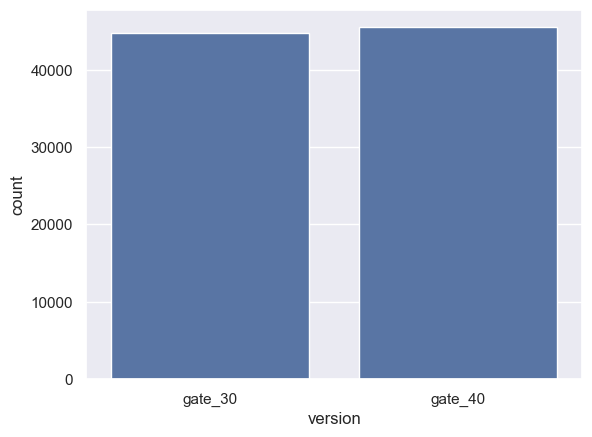

In [6]:
# Визуализация количества записей в столбце 'version'
sns.countplot(x = 'version', data = df)

#### Столбец 'retention_1'

In [7]:
# Проверка количества уникальных записей среди всех записей в столбце 'retention_1'
df.retention_1.nunique()

2

In [8]:
# Проверка количества уникальных совпадений по 'retention_1' среди всех записей
df.retention_1.value_counts(normalize = True)

retention_1
False    0.55479
True     0.44521
Name: proportion, dtype: float64

<Axes: xlabel='retention_1', ylabel='count'>

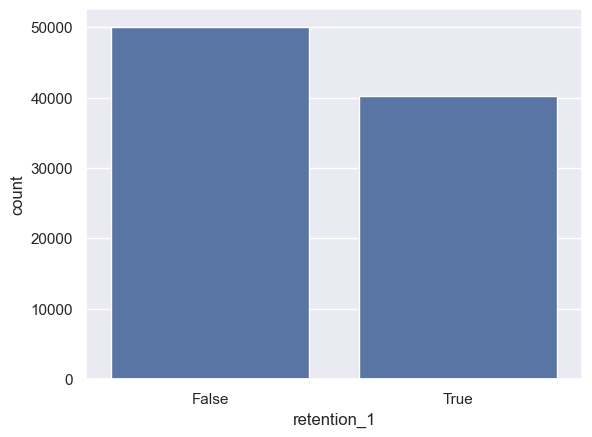

In [9]:
# Визуализация количества записей в столбце 'retention_1'
sns.countplot(x = 'retention_1', data = df)

#### Столбец 'retention_7'

In [10]:
# Проверка количества уникальных записей среди всех записей в столбце 'retention_7'
df.retention_7.nunique()

2

In [11]:
# Проверка количества уникальных совпадений по 'retention_7' среди всех записей
df.retention_7.value_counts(normalize = True)

retention_7
False    0.813935
True     0.186065
Name: proportion, dtype: float64

<Axes: xlabel='retention_7', ylabel='count'>

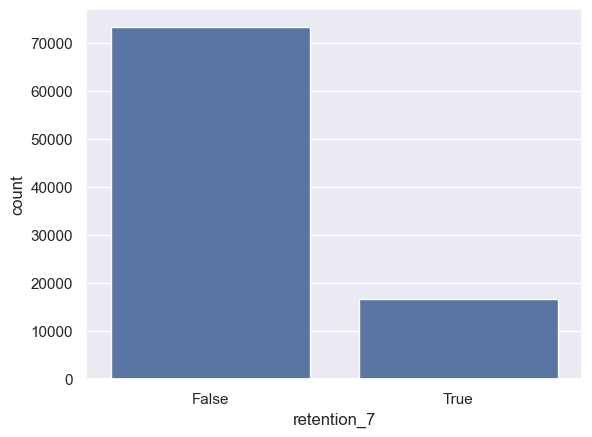

In [12]:
# Визуализация количества записей в столбце 'retention_7'
sns.countplot(x = 'retention_7', data = df)

### Количественные данные

#### Столбец 'sum_gamerounds'

In [13]:
# Посмотрим описательные статистики 'sum_gamerounds' и распределение по перцентилям
df.sum_gamerounds.describe(percentiles = [0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
85%         92.000000
95%        221.000000
99%        493.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

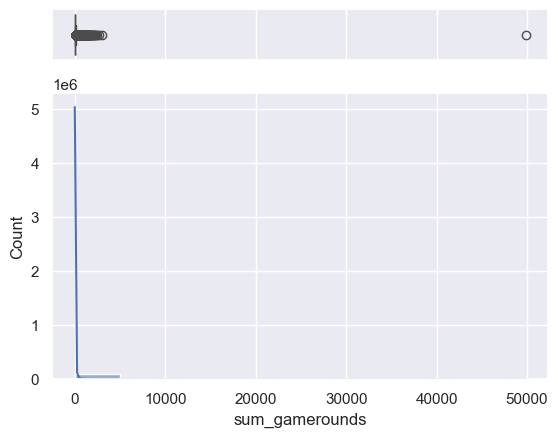

In [14]:
fig, (ax_box, ax_hist) = plt.subplots(2, # две строки в сетке подграфиков,
                                    sharex = True, # единая шкала по оси x 
                                    gridspec_kw = {'height_ratios': (.15, .85)}) # пропорция 15/85 по высоте

sns.boxplot(x = df['sum_gamerounds'], ax = ax_box)
sns.histplot(data = df, x = 'sum_gamerounds', ax = ax_hist, bins = 10, kde = True)

plt.show()

In [15]:
# Очистим датасет от выброса - удалим одно самое большое и отличающееся от остальных значение
first_outlier = df.sum_gamerounds.max()
df = df[df.sum_gamerounds < first_outlier]

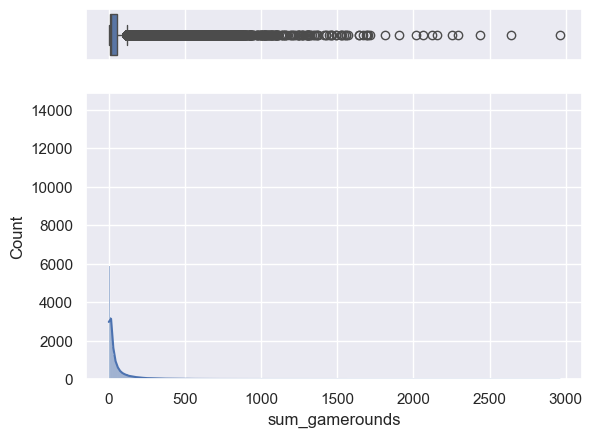

In [16]:
fig, (ax_box, ax_hist) = plt.subplots(2, # две строки в сетке подграфиков,
                                    sharex = True, # единая шкала по оси x 
                                    gridspec_kw = {'height_ratios': (.15, .85)}) # пропорция 15/85 по высоте

sns.boxplot(x = df['sum_gamerounds'], ax = ax_box)
sns.histplot(data = df, x = 'sum_gamerounds', ax = ax_hist, kde = True)

plt.show()

In [17]:
df.sum_gamerounds.describe(percentiles = [0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
85%         92.000000
95%        221.000000
99%        493.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

## Вторичный обзор датасета 

In [18]:
# Выполним вторичный обзор датасета
overview_df(df)

---------------------------------------- HEAD OF DATAFRAME ----------------------------------------- 
    userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
---------------------------------------- INFO OF DATAFRAME -----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 90188 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90188 non-null  int64 
 1   version         90188 non-null  object
 2   sum_gamerounds  90188 non-null  int64 
 3   retention_1     90188 non-null  bool  
 4   retention_7     90188 non-null  bool  
dtypes: bool(2), in

## 2 этап -- нахождение различий

In [19]:
# Посчитаем метрики sum_gamerounds, retention_1, retention_7 для каждой версии игры
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44699,44699,44699,44699
gate_40,45489,45489,45489,45489


### Два категориальных признака

In [20]:
# Таблица сопряженности для version и retention_1
crosstab_retention_1 = pd.crosstab(df['version'], df['retention_1'], normalize='index')
crosstab_retention_1.columns = ['Не вернулись', 'Вернулись']
crosstab_retention_1 = crosstab_retention_1.reset_index()

# Таблица сопряженности для version и retention_7
crosstab_retention_7 = pd.crosstab(df['version'], df['retention_7'], normalize='index')
crosstab_retention_7.columns = ['Не вернулись', 'Вернулись']
crosstab_retention_7 = crosstab_retention_7.reset_index()

print('Таблица сопряженности для version и retention_1:')
print(crosstab_retention_1, '\n')

print('Таблица сопряженности для version и retention_7:')
print(crosstab_retention_7)

Таблица сопряженности для version и retention_1:
   version  Не вернулись  Вернулись
0  gate_30      0.551802   0.448198
1  gate_40      0.557717   0.442283 

Таблица сопряженности для version и retention_7:
   version  Не вернулись  Вернулись
0  gate_30      0.809817   0.190183
1  gate_40      0.818000   0.182000


In [21]:
# Процентное соотношение каждой категории 
version_counts = df['version'].value_counts(normalize = True) * 100
retention_1_counts = df['retention_1'].value_counts(normalize = True) * 100
retention_7_counts = df['retention_7'].value_counts(normalize = True) * 100

print('Процентное соотношение каждой категории в version:')
print(version_counts, '\n')
print('Процентное соотношение каждой категории в retention_1:' )
print(retention_1_counts, '\n')
print('Процентное соотношение каждой категории в retention_7:')
print(retention_7_counts)

Процентное соотношение каждой категории в version:
version
gate_40    50.437974
gate_30    49.562026
Name: proportion, dtype: float64 

Процентное соотношение каждой категории в retention_1:
retention_1
False    55.478556
True     44.521444
Name: proportion, dtype: float64 

Процентное соотношение каждой категории в retention_7:
retention_7
False    81.394421
True     18.605579
Name: proportion, dtype: float64


#### 'version' by Retention 1/7 Day

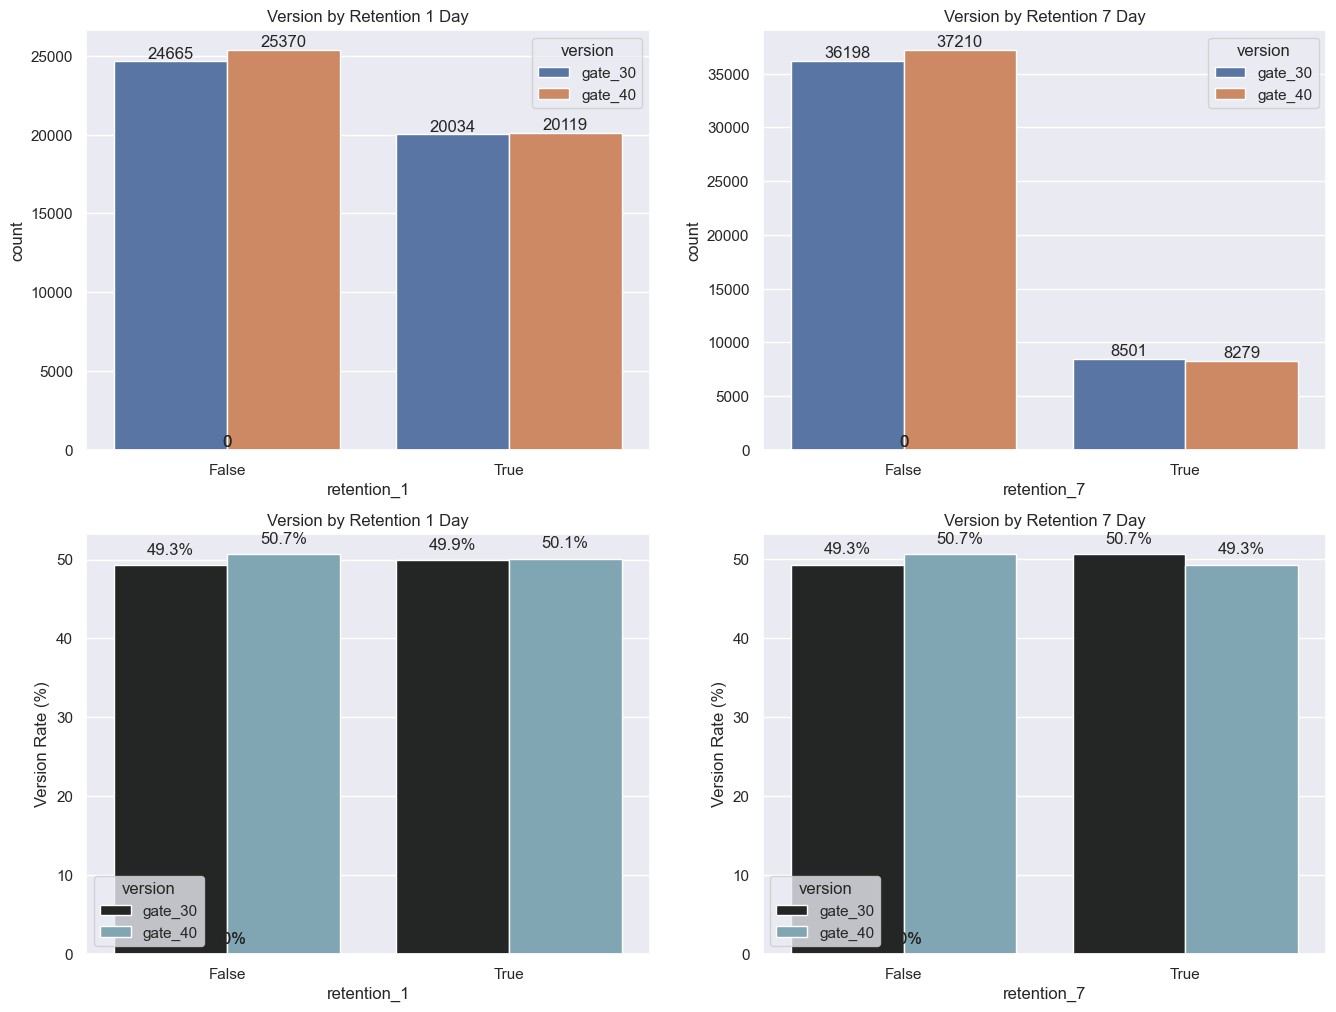

In [22]:
fig, axes = plt.subplots(2, 2, figsize = (16, 12))

sns.countplot(ax = axes[0, 0], data = df, x = "retention_1", hue = "version")
for i in axes[0, 0].patches:
    height = i.get_height()
    axes[0, 0].text(i.get_x() + i.get_width() / 2., height + 1, f'{height:.0f}', ha = 'center', va = 'bottom')
axes[0, 0].set_title('Version by Retention 1 Day')

sns.countplot(ax = axes[0, 1], data = df, x = "retention_7", hue = "version")
for i in axes[0, 1].patches:
    height = i.get_height()
    axes[0, 1].text(i.get_x() + i.get_width() / 2., height + 1, f'{height:.0f}', ha = 'center', va = 'bottom')
axes[0, 1].set_title('Version by Retention 7 Day')

version_by_retention_1 = df.groupby(['retention_1', 'version']).size().reset_index(name = 'counts')
version_by_retention_1['percentage'] = version_by_retention_1['counts'] / version_by_retention_1.groupby('retention_1')['counts'].transform('sum') * 100
sns.barplot(ax = axes[1, 0], x = 'retention_1', y = 'percentage', hue = 'version', data = version_by_retention_1, palette = 'dark:#7AB')
for p in axes[1, 0].patches:
    height = p.get_height()
    axes[1, 0].text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha = 'center', va = 'bottom')
axes[1, 0].set_title('Version by Retention 1 Day')
axes[1, 0].set_ylabel('Version Rate (%)')

version_by_retention_7 = df.groupby(['retention_7', 'version']).size().reset_index(name = 'counts')
version_by_retention_7['percentage'] = version_by_retention_7['counts'] / version_by_retention_7.groupby('retention_7')['counts'].transform('sum') * 100
sns.barplot(ax = axes[1, 1], x = 'retention_7', y = 'percentage', hue = 'version', data = version_by_retention_7, palette = 'dark:#7AB')
for p in axes[1, 1].patches:
    height = p.get_height()
    axes[1, 1].text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha = 'center', va = 'bottom')
axes[1, 1].set_title('Version by Retention 7 Day')
axes[1, 1].set_ylabel('Version Rate (%)')

plt.show()

#### Retention 1/7 Day by 'version'

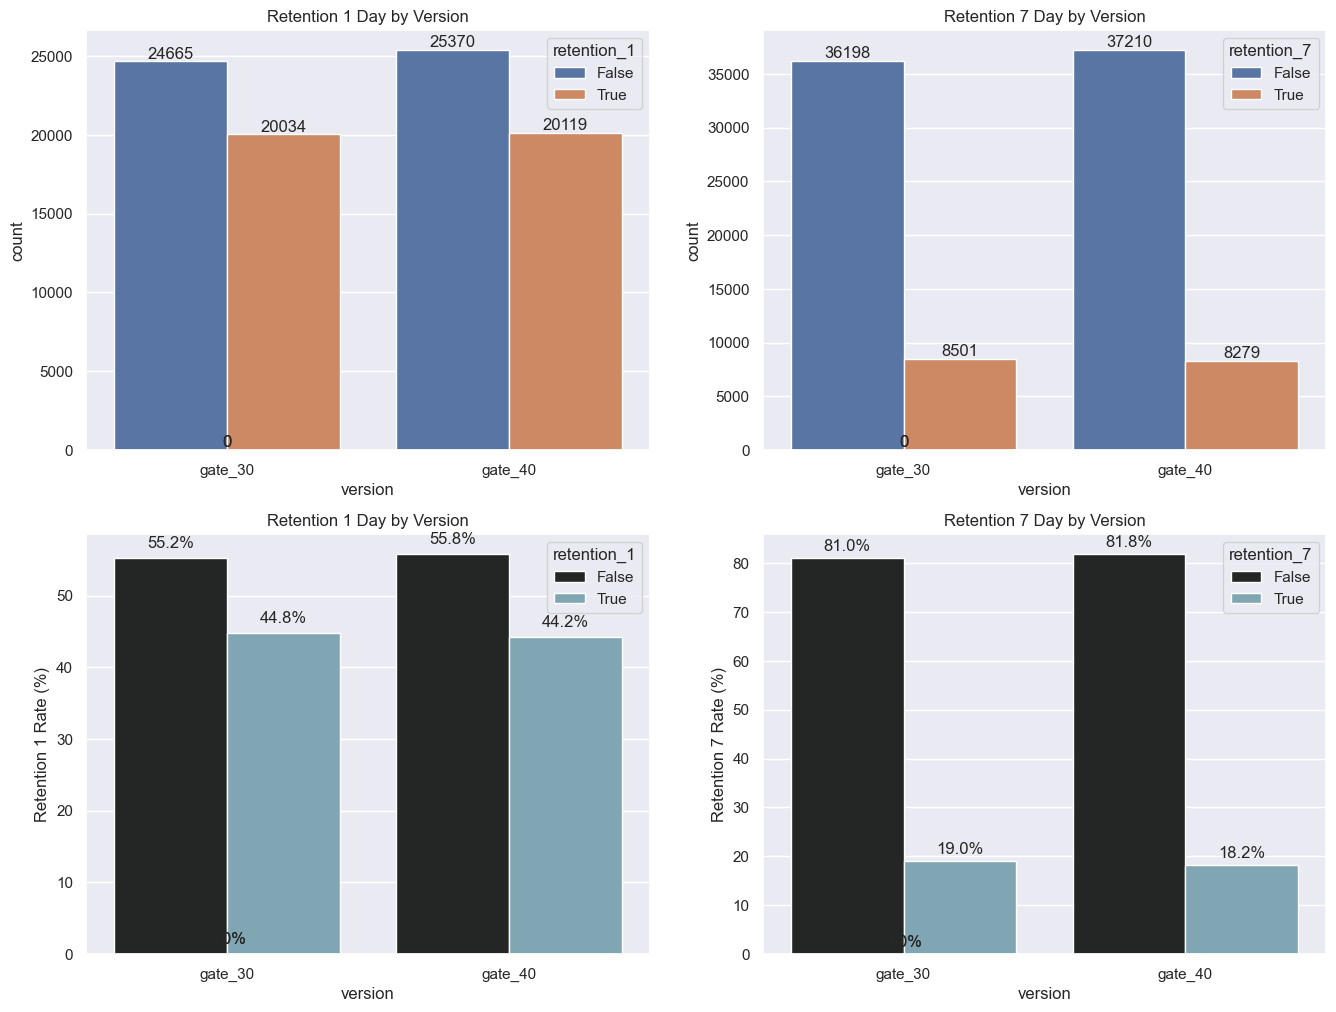

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (16, 12))

sns.countplot(ax = axes[0, 0], data = df, x = "version", hue = "retention_1")
for i in axes[0, 0].patches:
    height = i.get_height()
    axes[0, 0].text(i.get_x() + i.get_width() / 2., height + 1, f'{height:.0f}', ha = 'center', va = 'bottom')
axes[0, 0].set_title('Retention 1 Day by Version')

sns.countplot(ax = axes[0, 1], data = df, x = "version", hue = "retention_7")
for i in axes[0, 1].patches:
    height = i.get_height()
    axes[0, 1].text(i.get_x() + i.get_width() / 2., height + 1, f'{height:.0f}', ha = 'center', va = 'bottom')
axes[0, 1].set_title('Retention 7 Day by Version')

# Анализ retention_1 по версиям
retention_1_by_version = df.groupby(['version', 'retention_1']).size().reset_index(name = 'counts')
retention_1_by_version['percentage'] = retention_1_by_version['counts'] / retention_1_by_version.groupby('version')['counts'].transform('sum') * 100
sns.barplot(ax = axes[1, 0], x = 'version', y = 'percentage', hue = 'retention_1', data = retention_1_by_version, palette = 'dark:#7AB')
for p in axes[1, 0].patches:
    height = p.get_height()
    axes[1, 0].text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha = 'center', va = 'bottom')
axes[1, 0].set_title('Retention 1 Day by Version')
axes[1, 0].set_ylabel('Retention 1 Rate (%)')

# Анализ retention_7 по версиям
retention_7_by_version = df.groupby(['version', 'retention_7']).size().reset_index(name = 'counts')
retention_7_by_version['percentage'] = retention_7_by_version['counts'] / retention_7_by_version.groupby('version')['counts'].transform('sum') * 100
sns.barplot(ax = axes[1, 1], x = 'version', y = 'percentage', hue = 'retention_7', data = retention_7_by_version, palette = 'dark:#7AB')
for i in axes[1, 1].patches:
    height = i.get_height()
    axes[1, 1].text(i.get_x() + i.get_width() / 2., height + 1, f'{height:.1f}%', ha = 'center', va = 'bottom')
axes[1, 1].set_title('Retention 7 Day by Version')
axes[1, 1].set_ylabel('Retention 7 Rate (%)')

plt.show()

### Количественный и категориальный признаки

#### 'sum_gamerounds' and 'version'

In [24]:
# Посчитаем, сколько пользователей достигло каждых из ворот
df.groupby('version').agg({'sum_gamerounds': 'count'})

,sum_gamerounds
version,
gate_30,44699
gate_40,45489


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

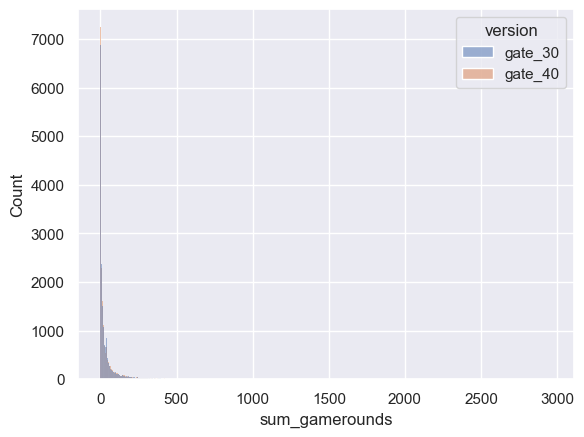

In [25]:
# Построим гистограмму распределения sum_gamerounds по version
# в библиотеке Seaborn в x мы поместим количественный признак, в hue - категориальный
sns.histplot(x = 'sum_gamerounds', hue = 'version', data = df) 

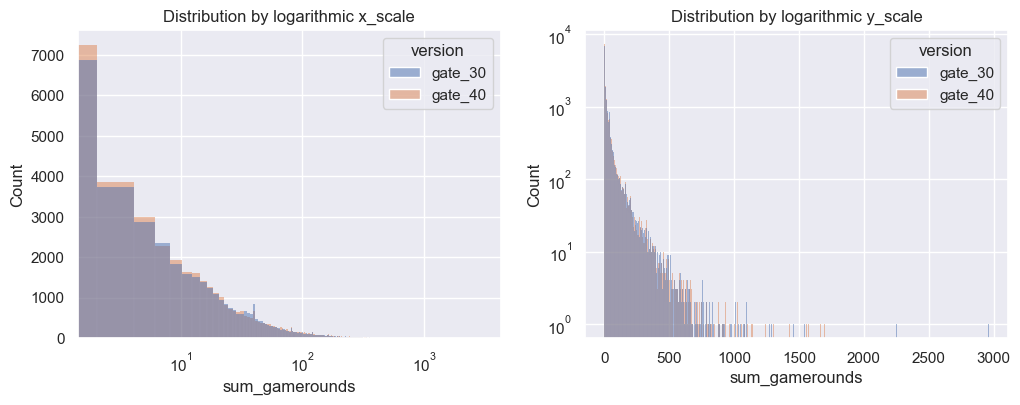

In [26]:
# Построим в логарифмической шкале

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(ax = axes[0], x = 'sum_gamerounds', hue = 'version', data = df)
axes[0].set_title('Distribution by logarithmic x_scale')
axes[0].set_xscale('log')

sns.histplot(ax = axes[1], x = 'sum_gamerounds', hue = 'version', data = df)
axes[1].set_title('Distribution by logarithmic y_scale')
axes[1].set_yscale('log')

plt.show()

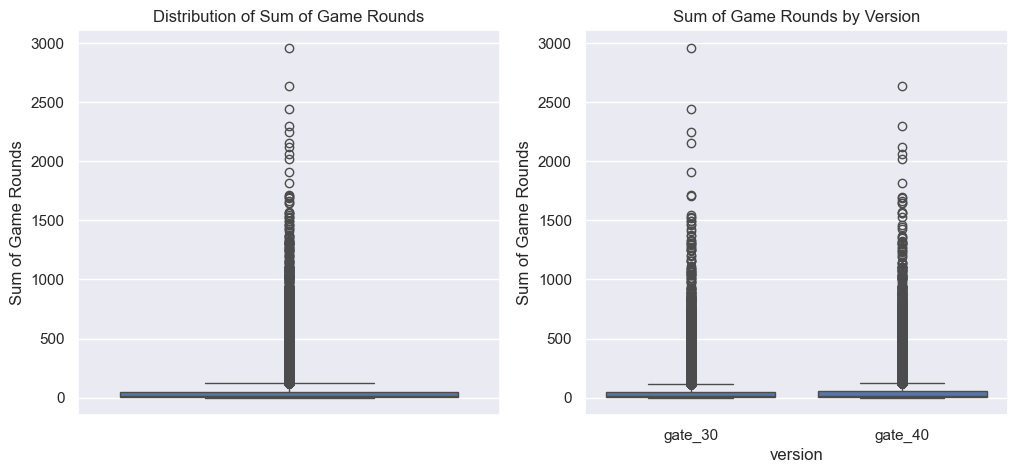

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Rounds')
axes[0].set_ylabel('Sum of Game Rounds')

# Распределение "sum_gamerounds" в виде 'ящика с усами' по версиям
sns.boxplot(ax = axes[1], x = 'version', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by Version')
axes[1].set_ylabel('Sum of Game Rounds')

plt.show()

<Axes: xlabel='sum_gamerounds', ylabel='version'>

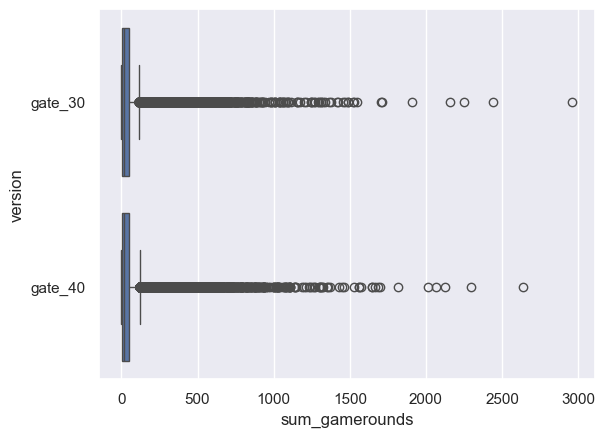

In [28]:
# Посмотрим на распределение по версиям более развернуто 

sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')

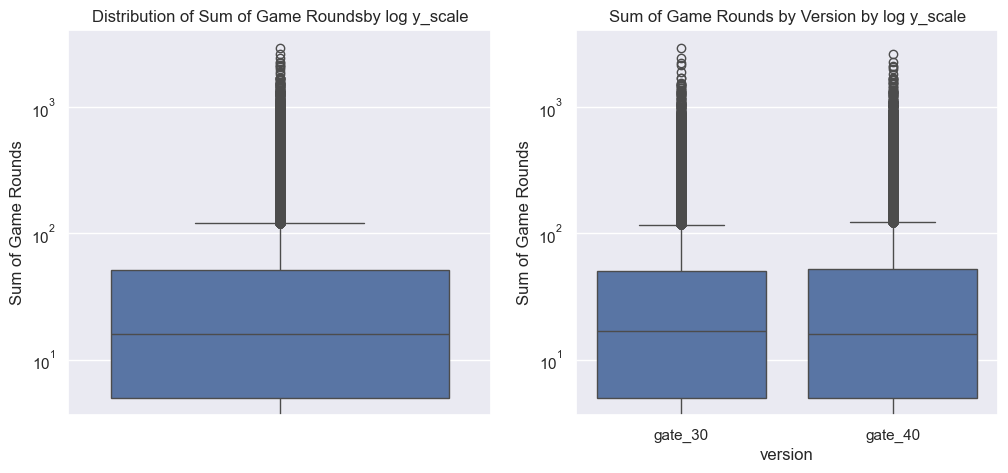

In [29]:
# Построим те же распределения в логарифмической шкале оси y
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Roundsby log y_scale')
axes[0].set_ylabel('Sum of Game Rounds')
axes[0].set_yscale('log')

# Анализ sum_gamerounds по версиям
sns.boxplot(ax = axes[1], x = 'version', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by Version by log y_scale')
axes[1].set_ylabel('Sum of Game Rounds')
axes[1].set_yscale('log')

plt.show()

#### 'sum_gamerounds' and 'retention_1'

In [30]:
# Посчитаем, сколько пользователей удержались и не удержались после 1-го дня
df.groupby('retention_1').agg({'sum_gamerounds': 'count'})

,sum_gamerounds
retention_1,
False,50035
True,40153


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

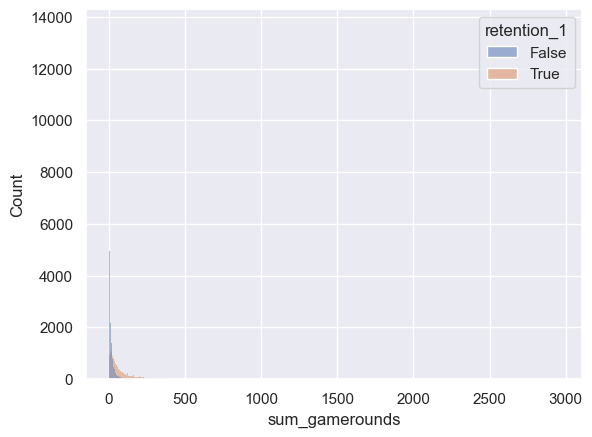

In [31]:
# Построим гистограмму распределения sum_gamerounds по True/False значениям retention_1
sns.histplot(x = 'sum_gamerounds', hue = 'retention_1', data = df)

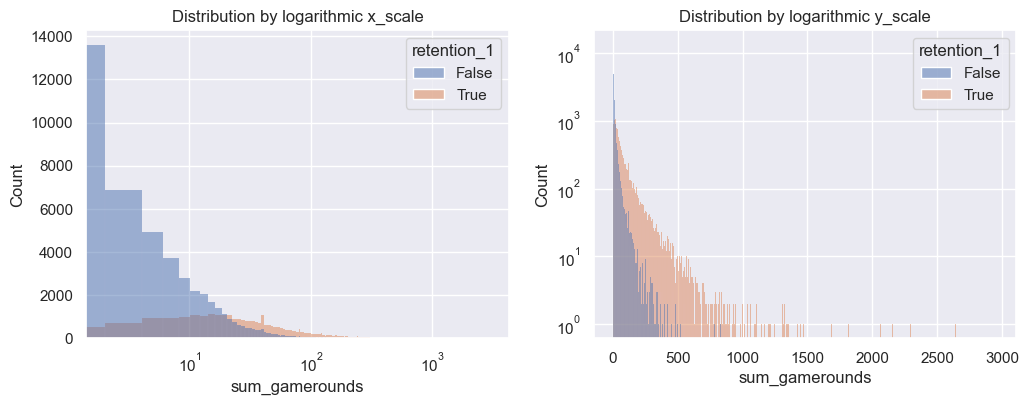

In [32]:
# Построим в логарифмической шкале

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(ax = axes[0], x = 'sum_gamerounds', hue = 'retention_1', data = df)
axes[0].set_title('Distribution by logarithmic x_scale')
axes[0].set_xscale('log')

sns.histplot(ax = axes[1], x = 'sum_gamerounds', hue = 'retention_1', data = df)
axes[1].set_title('Distribution by logarithmic y_scale')
axes[1].set_yscale('log')

plt.show()

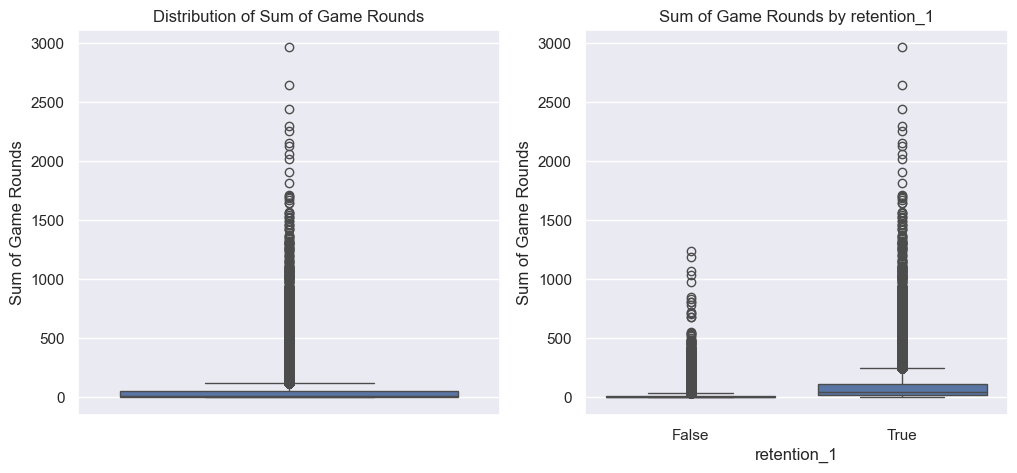

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Rounds')
axes[0].set_ylabel('Sum of Game Rounds')

# Распределение "sum_gamerounds" в виде 'ящика с усами' по версиям
sns.boxplot(ax = axes[1], x = 'retention_1', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by retention_1')
axes[1].set_ylabel('Sum of Game Rounds')

plt.show()

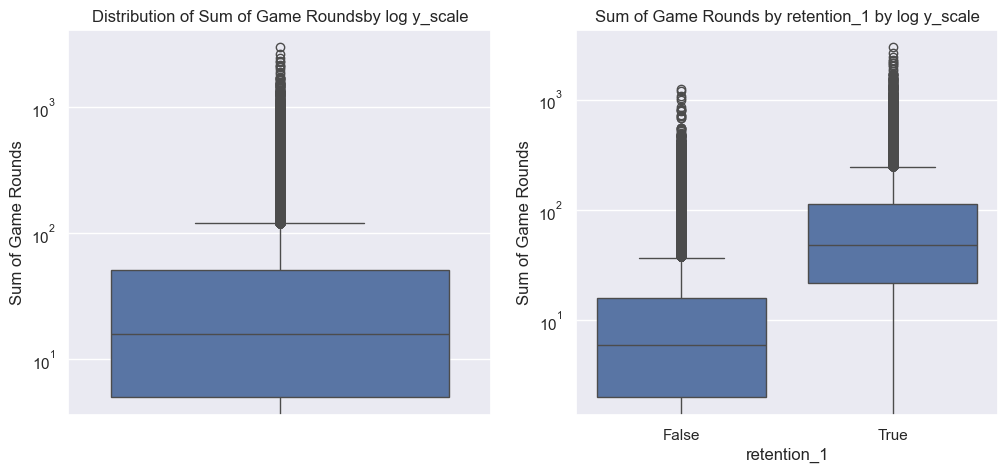

In [34]:
# Построим те же распределения в логарифмической шкале оси y
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Roundsby log y_scale')
axes[0].set_ylabel('Sum of Game Rounds')
axes[0].set_yscale('log')

# Анализ sum_gamerounds по версиям
sns.boxplot(ax = axes[1], x = 'retention_1', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by retention_1 by log y_scale')
axes[1].set_ylabel('Sum of Game Rounds')
axes[1].set_yscale('log')

plt.show()

#### 'sum_gamerounds' and 'retention_7'

In [35]:
# Посчитаем, сколько пользователей удержались и не удержались после 7-го дня
df.groupby('retention_7').agg({'sum_gamerounds': 'count'})

,sum_gamerounds
retention_7,
False,73408
True,16780


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

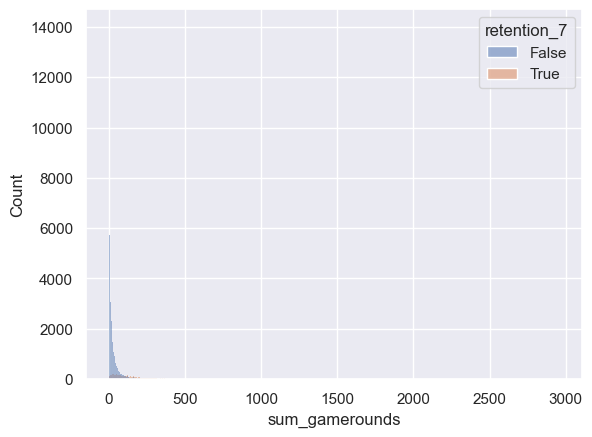

In [36]:
# Построим гистограмму распределения sum_gamerounds по True/False значениям retention_7
sns.histplot(x = 'sum_gamerounds', hue = 'retention_7', data = df)

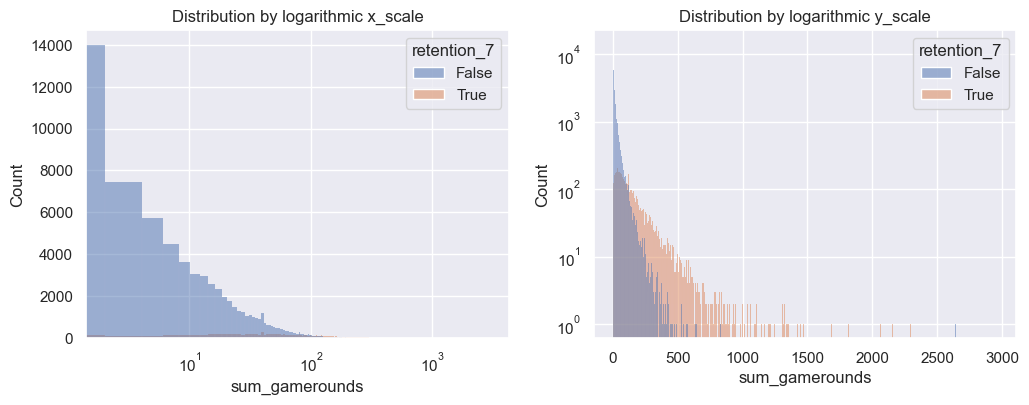

In [37]:
# Построим в логарифмической шкале

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(ax = axes[0], x = 'sum_gamerounds', hue = 'retention_7', data = df)
axes[0].set_title('Distribution by logarithmic x_scale')
axes[0].set_xscale('log')

sns.histplot(ax = axes[1], x = 'sum_gamerounds', hue = 'retention_7', data = df)
axes[1].set_title('Distribution by logarithmic y_scale')
axes[1].set_yscale('log')

plt.show()

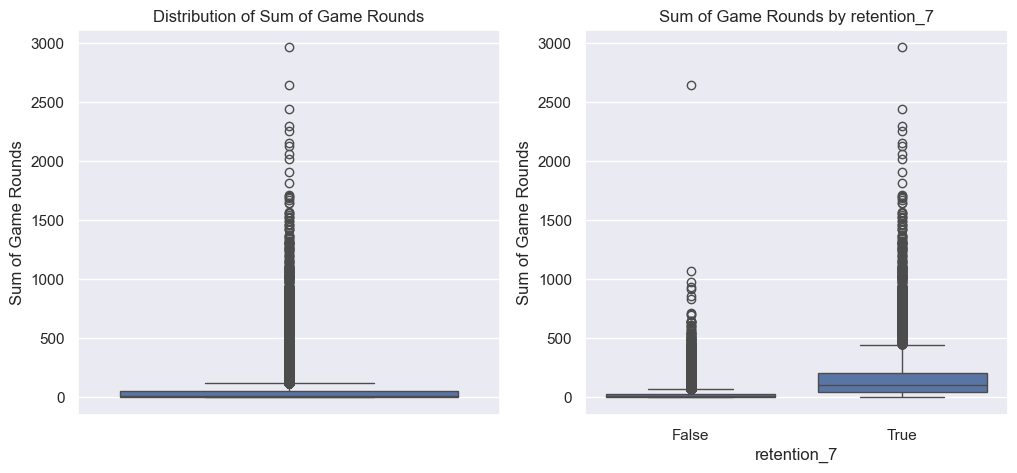

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Rounds')
axes[0].set_ylabel('Sum of Game Rounds')

# Распределение "sum_gamerounds" в виде 'ящика с усами' по версиям
sns.boxplot(ax = axes[1], x = 'retention_7', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by retention_7')
axes[1].set_ylabel('Sum of Game Rounds')

plt.show()

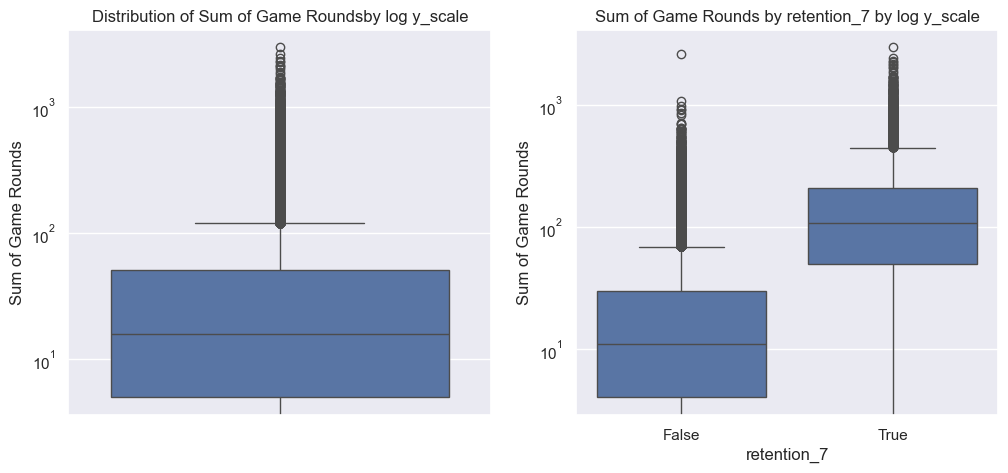

In [39]:
# Построим те же распределения в логарифмической шкале оси y
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Roundsby log y_scale')
axes[0].set_ylabel('Sum of Game Rounds')
axes[0].set_yscale('log')

# Анализ sum_gamerounds по версиям
sns.boxplot(ax = axes[1], x = 'retention_7', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by retention_7 by log y_scale')
axes[1].set_ylabel('Sum of Game Rounds')
axes[1].set_yscale('log')

plt.show()

In [40]:
# Очистим датасет от выброса - удалим одно самое большое и отличающееся от остальных значение 
f = df[df['retention_7'] == False]
outlier = f.sum_gamerounds.max()
outlier_index = df[ df.sum_gamerounds == outlier].index

df.drop(outlier_index, inplace = True)

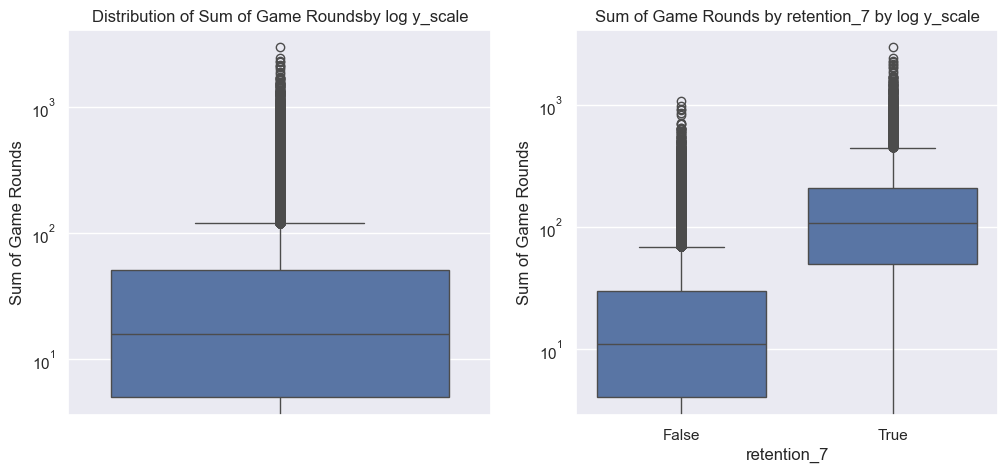

In [41]:
# Построим те же распределения в логарифмической шкале оси y
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Распределение "sum_gamerounds" в виде 'ящика с усами'
sns.boxplot(ax = axes[0], y = df['sum_gamerounds'])
axes[0].set_title('Distribution of Sum of Game Roundsby log y_scale')
axes[0].set_ylabel('Sum of Game Rounds')
axes[0].set_yscale('log')

# Анализ sum_gamerounds по версиям
sns.boxplot(ax = axes[1], x = 'retention_7', y = 'sum_gamerounds', data = df)
axes[1].set_title('Sum of Game Rounds by retention_7 by log y_scale')
axes[1].set_ylabel('Sum of Game Rounds')
axes[1].set_yscale('log')

plt.show()

# Постановка задачи A/B-тестирования

**Цель А/В-тестирования**: сравнить поведение пользователей двух версий игры - с двумя разными отметками границам проходных ворот, чтобы определить, есть ли существенная разница между ними после внесения изменений.

**Контрольная группа (А)**: пользователи с версией gate_30.<br>
**Тестовая группа (В)**: пользователи с версией gate_40.<br>

Во время обработки и анализа результатов данного эксперимента постараемся ответить на следующие три вопроса и **сформулируем** для этого соответствующие **гипотезы**:

- **Вопрос 1. Увеличилось ли среднее количество игровых сессий на 5 сессий?**<br>
**Цель:** Определить, увеличило ли лечение среднее количество игровых сессий на 5 сеансов.<br>

**Метрика** - среднее значение sum_gamerounds, **тип** - непрерывный.<br>
Нулевая гипотеза **(H0)**: **μ1 = μ2**. Статистически значимая разница в значениях метрики отсутствует. Среднее количество игровых сессий в тестовой группе не увеличилось на 5 сеансов по сравнению с контрольной группой.<br>
Альтернативная гипотеза **(H1)**: **μ1 ≠ μ2**. Статистически значимая разница в значениях метрики присутствует. Среднее количество игровых сессий в тестовой группе увеличилось на 5 сеансов по сравнению с контрольной группой.
    
- **Вопрос 2. Увеличилось ли удержание (retention_1) игроков на 2% через 1 день?**<br>
**Цель:** Определить, увеличило ли лечение удержание игроков на 2% через день после установки.<br>

**Метрика** - среднее значение retention_1, **тип** - дискретный.<br>
Нулевая гипотеза **(H0)**: **μ1 = μ2**. Статистически значимая разница в значениях метрики отсутствует. Уровень удержания игроков через день после установки в тестовой группе не увеличился на 2% по сравнению с контрольной группой.<br>
Альтернативная гипотеза **(H1)**: **μ1 ≠ μ2**. Статистически значимая разница в значениях метрики присутствует. Уровень удержания игроков через день после установки в тестовой группе увеличился на 2% по сравнению с контрольной группой.
    
- **Вопрос 3. Увеличилось ли удержание (retention_7) игроков на 5% через 7 дней?**<br>
**Цель:** Определить, увеличило ли лечение удержание игроков на 5% через семь дней после установки.<br>

**Метрика** - среднее значение retention_7, **тип** - дискретный.<br>
Нулевая гипотеза **(H0)**: **μ1 = μ2**. Статистически значимая разница в значениях метрики отсутствует. Уровень удержания игроков через семь дней после установки в тестовой группе имеет не увеличилось на 5% по сравнению с контрольной группой.<br>
Альтернативная гипотеза **(H1)**: **μ1 ≠ μ2**. Статистически значимая разница в значениях метрики присутствует. Уровень удержания игроков через семь дней после установки в тестовой увеличился на 5% по сравнению с контрольной группой.

In [42]:
# Сформируем контрольную и тестовую группы

control_group = df[df['version'] == 'gate_30']
test_group = df[df['version'] == 'gate_40']

In [43]:
print('Изначальный размер контрольной группы А: ', df[df['version'] == 'gate_30'].shape)
print('Изначальный размер тестовой группы В: ', df[df['version'] == 'gate_40'].shape)

Изначальный размер контрольной группы А:  (44699, 5)
Изначальный размер тестовой группы В:  (45488, 5)


# Подготовка к A/B-тестированию

## Предварительная обработка данных

Очистим датасет от выбросов с помощью метода межквартильного размаха (IQR).

* **Метод IQR** используется для измерения изменчивости путем разделения набора данных на квартили. Данные сортируются в порядке возрастания и делятся на 4 равные части. Первый, второй, третий квартили (Q1, Q2, Q3) - это значения, которые разделяют набор данных на 4 равные части.

* Q1 представляет собой 25-й перцентиль данных. Q2 представляет 50-ю перцентиль данных. Q3 представляет 75-ю перцентиль данных.

* IQR - это диапазон между первым и третьим квартилями (Q1 и Q3): **IQR = Q3 – Q1**. 
Точки данных, которые попадают ниже Q1 – 1,5 IQR или выше Q3 + 1,5 IQR, являются **выбросами**.

Функция для реализации данного метода выполнена в разделе вспомогательных функций.

In [44]:
# Применим метод к сформированным группам

control_group = df_IQR(control_group, 'sum_gamerounds')
test_group = df_IQR(test_group, 'sum_gamerounds')

In [45]:
print('Размер контрольной группы А, очищенной от выбросов: ', control_group.shape)
print('Размер тестовой группы В, очищенной от выбросов: ', test_group.shape)

Размер контрольной группы А, очищенной от выбросов:  (39493, 5)
Размер тестовой группы В, очищенной от выбросов:  (40471, 5)


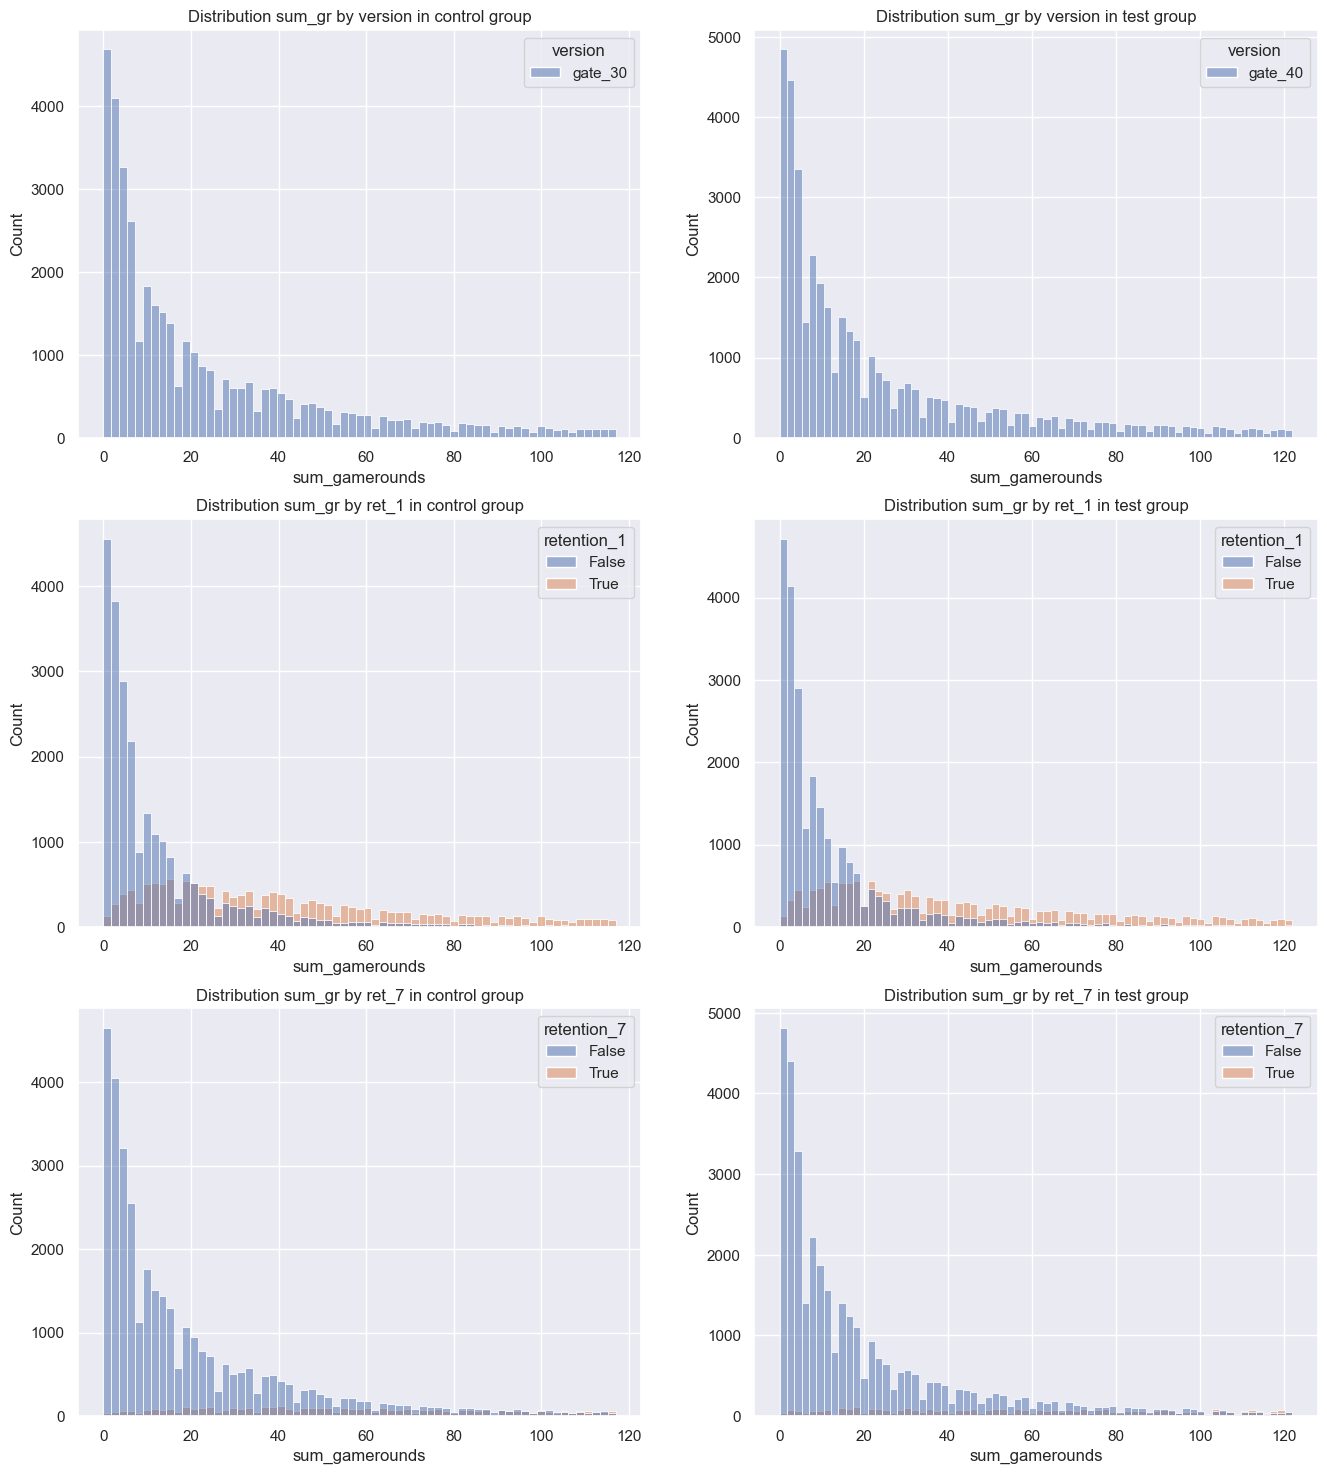

In [60]:
fig, axes = plt.subplots(3, 2, figsize = (16, 18))

sns.histplot(ax = axes[0, 0], x = 'sum_gamerounds', hue = 'version', data = control_group)
axes[0, 0].set_title('Distribution sum_gr by version in control group')

sns.histplot(ax = axes[0, 1], x = 'sum_gamerounds', hue = 'version', data = test_group)
axes[0, 1].set_title('Distribution sum_gr by version in test group')

sns.histplot(ax = axes[1, 0], x = 'sum_gamerounds', hue = 'retention_1', data = control_group)
axes[1, 0].set_title('Distribution sum_gr by ret_1 in control group')

sns.histplot(ax = axes[1, 1], x = 'sum_gamerounds', hue = 'retention_1', data = test_group)
axes[1, 1].set_title('Distribution sum_gr by ret_1 in test group')

sns.histplot(ax = axes[2, 0], x = 'sum_gamerounds', hue = 'retention_7', data = control_group)
axes[2, 0].set_title('Distribution sum_gr by ret_7 in control group')

sns.histplot(ax = axes[2, 1], x = 'sum_gamerounds', hue = 'retention_7', data = test_group)
axes[2, 1].set_title('Distribution sum_gr by ret_7 in test group')

plt.show()

## Установка вероятности ошибок l и ll рода

При проверке гипотез важно установить допустимые вероятности ошибок I и II рода, чтобы утверждать достоверность результатов нашего тестирования.

* **Ошибка I рода (α)** - вероятность отклонения нулевой гипотезы, когда она на самом деле верна. Другими словами, это представляет риск заключения о наличии эффекта или разницы, когда на самом деле их нет.

Принято устанавливать α = 0,05 (5%). Это означает, что существует 5%-ный риск совершения ошибки I рода.

Тогда в терминах ошибки I рода можно сформулировать интерпретации результатов наших A/B-тестов, которые вычислим в дальнейшем:

**Вопрос 1:** Если мы ошибочно заключаем, что среднее количество игровых сессий увеличилось на 5 сеансов, хотя этого не произошло, мы совершаем ошибку I рода.<br>
**Вопрос 2:** Если мы ошибочно заключаем, что удержание игроков увеличилось на 2% через 1 день, когда этого не произошло, мы совершаем ошибку I рода.<br>
**Вопрос 3:** Если мы ошибочно заключаем, что удержание игроков увеличилось на 5% через 7 дней, когда этого не произошло, мы совершаем ошибку I рода.


* **Ошибка II рода (β)** - вероятность того, что нулевая гипотеза не будет отклонена, когда она на самом деле неверна. Другими словами, это представляет риск заключения об отсутствии эффекта или разницы, когда на самом деле она есть.

Установим β = 0,2 (20%). Это означает, что существует 20%-ный риск совершения ошибки II рода.

**Мощность теста:** мощность теста определяется как 1 − β. Тогда в нашем случае значение мощности равно 0,8 (80%), что говорит о 80%-ной вероятности правильного отклонения нулевой гипотезы, когда она неверна.

Теперь точно также в терминах ошибки II рода можно сформулировать интерпретации результатов наших A/B-тестов, которые вычислим в дальнейшем:

**Вопрос 1:** Если нам не удается обнаружить фактическое увеличение среднего количества игровых сессий на 5 сеансов, мы совершаем ошибку II рода.<br>
**Вопрос 2:** Если нам не удается обнаружить фактическое увеличение удержания игроков на 2% по истечении 1 дня, мы совершаем ошибку II рода.<br>
**Вопрос 3:** Если нам не удается обнаружить фактическое увеличение удержания игроков на 5% по истечении 7 дней, мы совершаем ошибку II рода.

* **Вероятности ошибок I и II рода** <br>
В итоге, будем использовать следующие значения для наших тестов:

**α:** 0.05 (5%)<br>
**β:** 0.2 (20%)<br>
**Мощность** (power)**:** 0.8 (80%)

Эти общепринятые значения обеспечивают баланс между минимизацией риска ошибок I и II рода и утверждают, что результаты наших тестов будут надежными и статистически значимыми.

In [61]:
# Определим вероятности ошибок I и II рода и мощность
alpha = 0.05
beta = 0.20
power = 1 - beta

## Вычисление необходимого размера выборок

* **Для непрерывных метрик:**

$$
n = \left( \frac{Z_{\alpha/2} + Z_{\beta}}{\mu_1 - \mu_2} \right)^2 \cdot 2\sigma^2 , 
$$

где
- $Z_{\alpha/2}$ - Z-оценка для выбранного уровня значимости.
- $Z_{\beta}$ - Z-оценка для выбранной степени.
- $\mu_1$ and $\mu_2$ - средние значения контрольной и тестовой групп соответственно.
- $\sigma$ - стандартное отклонение генеральной совокупности.

In [62]:
# Z-оценка для уровня значимости α и мощности
Z_alpha = stats.norm.ppf(1 - alpha / 2)
Z_beta = stats.norm.ppf(power)

In [63]:
# Определим значение размера эффекта для данной непрерывной метрики
effect = 5  # Разница в среднем количестве сеансов, которую хотим получить

# Вычислим стандартное отклонение столбца 'sum_gamerounds'
std_dev = pd.concat([control_group['sum_gamerounds'], test_group['sum_gamerounds']]).std()

# Вычислим необходимый размер выборки для непрерывной метрики с помощью statsmodels
sample_size_sum = int(((Z_alpha + Z_beta) * std_dev / effect) ** 2 * 2)

In [64]:
print('Необходимый размер выборки для теста про среднее количество игровых сессий: ', sample_size_sum)

Необходимый размер выборки для теста про среднее количество игровых сессий:  471


* **Для дискретных метрик:** <br>
Чтобы рассчитать размер выборки для A/B-теста с дискретной бинарной метрикой, нам нужно определить пропорции успеха как в контрольной, так и в тестовой группе. Формула для расчета требуемого размера выборки для каждой группы в бинарном A / B-тестировании выглядит следующим образом:

$$
n = \left( \frac{Z_{\alpha/2} + Z_{\beta}}{p_1 - p_2} \right)^2 \left( p_1(1 - p_1) + p_2(1 - p_2) \right) ,
$$

где
- $Z_{\alpha/2}$ - Z-оценка для выбранного уровня значимости.
- $Z_{\beta}$ - Z-оценка для выбранной мощности.
- $p_1$ - доля успеха в контрольной группе.
- $p_2$ - доля успеха в тестовой группе.

In [65]:
# Исходные и ожидаемые значения для коэффициента удержания 
p1_retention_1 = control_group['retention_1'].mean()
p2_retention_1 = p1_retention_1 + 0.02  # ожидаемое увеличение на 2% для коэффициента удержания через 1 день

p1_retention_7 = control_group['retention_7'].mean()
p2_retention_7 = p1_retention_7 + 0.05  # ожидмаемое увеличение на 5% для коэффициента удержания через 7 дней

# Функция для вычисления размера выборки для двоичного результата
def calculate_sample_size_binary(p1, p2, Z_alpha, Z_beta):
    pooled_prob = (p1 + p2) / 2
    return int(((Z_alpha * (2 * pooled_prob * (1 - pooled_prob)) ** 0.5 + Z_beta * (p1 * (1 - p1) + p2 * (1 - p2)) ** 0.5) / (p1 - p2)) ** 2)

# Вычисление необходимого размера выборок
sample_size_ret1 = calculate_sample_size_binary(p1_retention_1, p2_retention_1, Z_alpha, Z_beta)
sample_size_ret7 = calculate_sample_size_binary(p1_retention_7, p2_retention_7, Z_alpha, Z_beta)

In [66]:
print('Необходимый размер выборки для теста для коэффициента удержания после 1-го дня: ', sample_size_ret1)
print('Необходимый размер выборки для теста для коэффициента удержания после 7-го дня: ', sample_size_ret7)

Необходимый размер выборки для теста для коэффициента удержания после 1-го дня:  9397
Необходимый размер выборки для теста для коэффициента удержания после 7-го дня:  761


## Итоговое разбиение пользователей по группам

* **'sum_gamerounds':** <br>
Чтобы провести A/B-тест для суммы игровых раундов, нужно случайным образом распределить пользователей на контрольную и тестовую группы на основе рассчитанного размера выборки. Это гарантирует равную представленность пользователей обеих версий игры в каждой группе и достоверность результатов тестирования.

In [67]:
# Случайное разбиение пользователей для контрольной и тестовой групп на основе рассчитанного размера выборки по сумме игровых раундов
control_users_rounds = control_group.sample(n = int(sample_size_sum), random_state = 42)
test_users_rounds = test_group.sample(n = int(sample_size_sum), random_state = 42)

In [68]:
print('Размер выборки для контрольной группы А sum_gamerounds: ', len(control_users_rounds))
print('Размер выборки для тестовой группы В sum_gamerounds: ', len(test_users_rounds))

Размер выборки для контрольной группы А sum_gamerounds:  471
Размер выборки для тестовой группы В sum_gamerounds:  471


* **'retention_1':** <br>
Чтобы провести A/B-тест по измерению коэффициента удержания пользователя через 1 день (retention_1), нужно случайным образом распределить пользователей на контрольную и тестовую группу на основе рассчитанного размера выборки. Это гарантирует равную представленность пользователей обеих версий игры в каждой группе и достоверность/надежность результатов тестирования.

In [69]:
# Установим random seed - случайное начальное значение для генерации случайной выборки
np.random.seed(42)

# Случайный отбор пользователей в контрольную и тестовую группы на основе рассчитанного объема выборки для коэффициента удержания после 1-го дня
control_users_ret1 = control_group.sample(n = int(sample_size_ret1), random_state = 42)
test_users_ret1 = test_group.sample(n = int(sample_size_ret1), random_state = 42)

In [70]:
print('Размер выборки для контрольной группы А retention_1: ', len(control_users_ret1))
print('Размер выборки для тестовой группы В retention_1: ', len(test_users_ret1))

Размер выборки для контрольной группы А retention_1:  9397
Размер выборки для тестовой группы В retention_1:  9397


* **'retention_7':** <br>
Чтобы провести A/B-тест по измерению коэффициента удержания пользователя через 7 дней (retention_7), нужно случайным образом распределить пользователей на контрольную и тестовую группу на основе рассчитанного размера выборки. Это гарантирует равную представленность пользователей в каждой группе и достоверность/надежность результатов тестирования.

In [71]:
# Случайный отбор пользователей в контрольную и тестовую группы на основе рассчитанного объема выборки для коэффициента удержания после 7-го дня
control_users_ret7 = control_group.sample(n = int(sample_size_ret7), random_state = 43)
test_users_ret7 = test_group.sample(n = int(sample_size_ret7), random_state = 43)

In [72]:
print('Размер выборки для контрольной группы А retention_7: ', len(control_users_ret7))
print('Размер выборки для тестовой группы В retention_7: ', len(test_users_ret7))

Размер выборки для контрольной группы А retention_7:  761
Размер выборки для тестовой группы В retention_7:  761


# Обработка результатов A/B-тестирования

## Метрика sum_gamerounds

### Проверка на нормальность распределения

* Посмотрим как выглядит гистограмма и график QQ-Plot для непрерывной метрики **sum_gamerounds**

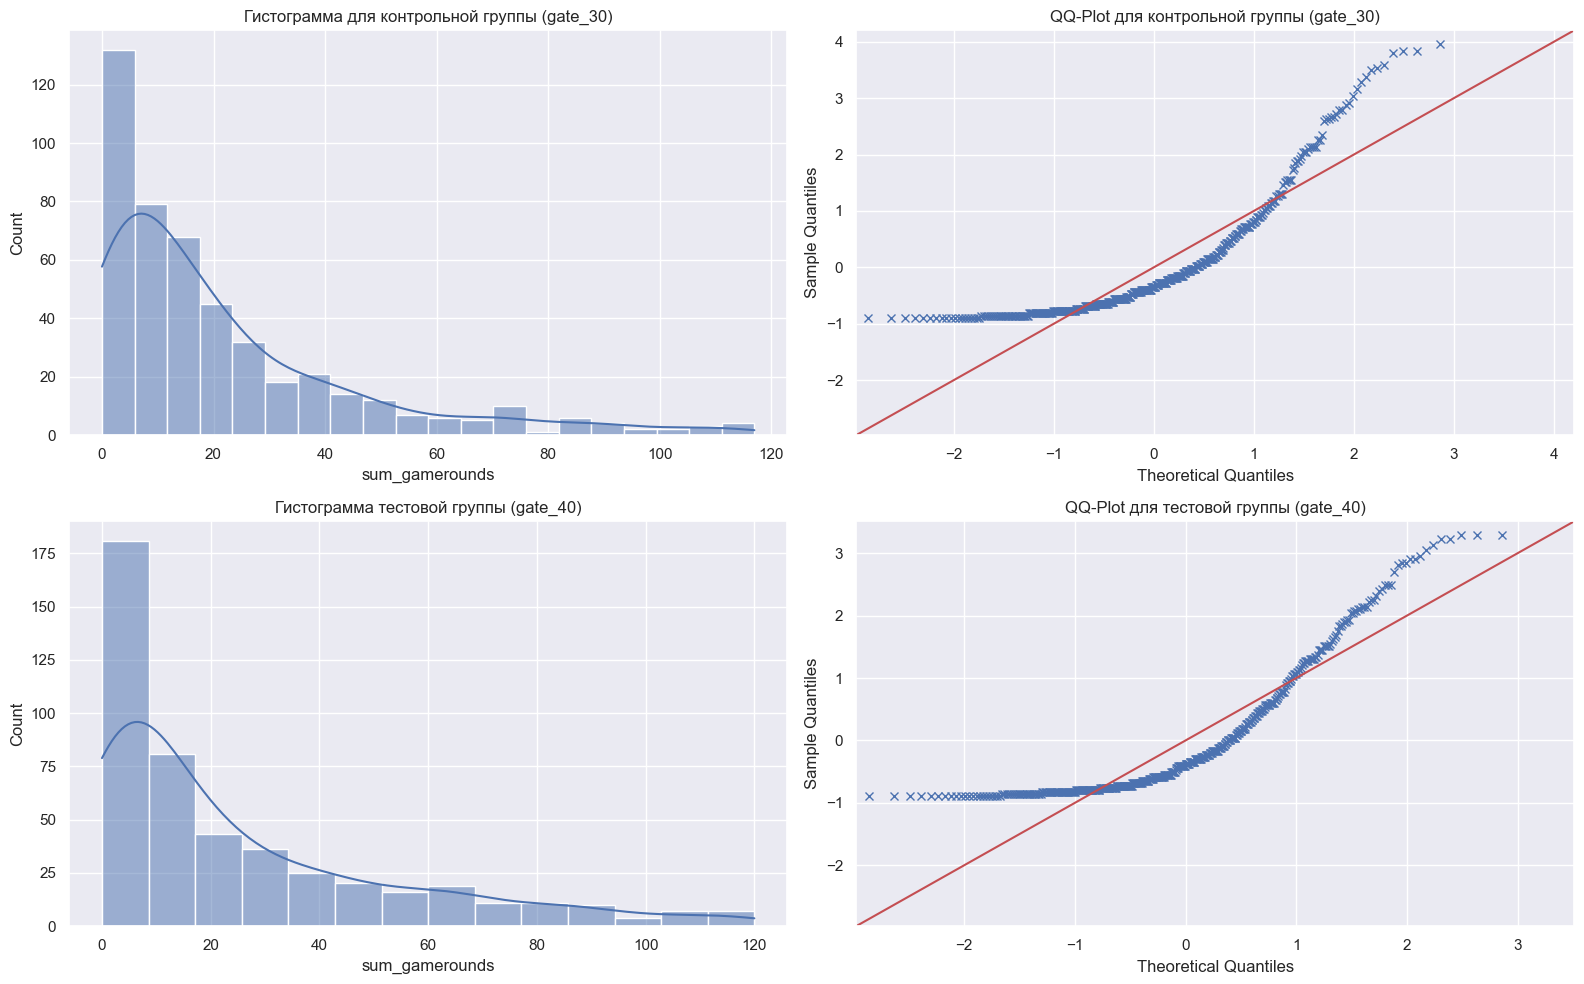

In [74]:
fig, axes = plt.subplots(2, 2, figsize = (16, 10))
axes = axes.ravel()

sns.histplot(data = control_users_rounds, x = 'sum_gamerounds', 
             ax = axes[0], kde = True).set_title('Гистограмма для контрольной группы (gate_30)')

axes[1].set_title('QQ-Plot для контрольной группы (gate_30)')

sns.histplot(data = test_users_rounds, x = 'sum_gamerounds', 
             ax = axes[2], kde = True).set_title('Гистограмма тестовой группы (gate_40)')

axes[3].set_title('QQ-Plot для тестовой группы (gate_40)')

with warnings.catch_warnings():
    
    warnings.simplefilter('ignore')
    
    sm.qqplot(control_users_rounds.sum_gamerounds, ax = axes[1], 
              marker = 'x', line = '45', fit = True)
    sm.qqplot(test_users_rounds.sum_gamerounds, ax = axes[3], 
              marker = 'x', line = '45', fit = True)

plt.tight_layout()
plt.show()

Видим логнормальное распределение данных, имеем визуальное подтверждение.

* Статистический **тест Шапиро-Уилка**

In [79]:
# Распределение пользователей по группам для метрики 'sum_gamerounds'
gamerounds_control = control_users_rounds['sum_gamerounds']
gamerounds_test = test_users_rounds['sum_gamerounds']

from scipy.stats import shapiro

# Вычислим стастистику теста Шапиро-Уилка и p-value для двух групп для проверки на нормальность
control_shapiro_stat, control_shapiro_p = stats.shapiro(gamerounds_control)
test_shapiro_stat, test_shapiro_p = stats.shapiro(gamerounds_test)

# Результаты для контрольной группы
print('Статистика теста Шапиро-Уилка для контрольной группы А: ', control_shapiro_stat)
print('P-value для контрольной группы А: ', control_shapiro_p)
if control_shapiro_p > 0.05:
    print('Следовательно, недостаточно доказательств для отклонения нулевой гипотезы. То есть выборка контрольной группы соответствует нормальному распределению).', '\n')
else:
    print('Следовательно, имеется достаточно доказательств, чтобы отвергнуть нулевую гипотезу. То есть выборка контрольной группы не соответствует нормальному распределению).', '\n')
    
# Результаты для тестовой группы
print('Статистика теста Шапиро-Уилка для тестовой группы В: ', test_shapiro_stat)
print('P-value для тестовой группы В: ', test_shapiro_p)
if test_shapiro_p > 0.05:
    print('Следовательно, недостаточно доказательств для отклонения нулевой гипотезы. То есть выборка тестовой группы соответствует нормальному распределению).', '\n')
else:
    print('Следовательно, имеется достаточно доказательств, чтобы отвергнуть нулевую гипотезу. То есть выборка тестовой группы не соответствует нормальному распределению).', '\n')

Статистика теста Шапиро-Уилка для контрольной группы А:  0.7898262043241926
P-value для контрольной группы А:  3.382678949866686e-24
Следовательно, имеется достаточно доказательств, чтобы отвергнуть нулевую гипотезу. То есть выборка контрольной группы не соответствует нормальному распределению). 

Статистика теста Шапиро-Уилка для тестовой группы В:  0.8117324621813317
P-value для тестовой группы В:  4.7932726177846814e-23
Следовательно, имеется достаточно доказательств, чтобы отвергнуть нулевую гипотезу. То есть выборка тестовой группы не соответствует нормальному распределению). 



Теперь имеем и статистическое подтверждение, что наши данные распределены не нормально. Значит, следует использовать непараметрические тесты для проверки данных вышеуказанной гипотезы.

### Проверка на однородность (равенство дисперсий) распределения

In [85]:
from scipy.stats import ttest_ind, levene

# Определим уровень значимости 
alpha = 0.05

# Рассчитаем средние значения и стандартные отклонения суммы игровых раундов в обеих группах
mean_control_rounds = control_users_rounds['sum_gamerounds'].mean()
mean_test_rounds = test_users_rounds['sum_gamerounds'].mean()
std_control_rounds = control_users_rounds['sum_gamerounds'].std()
std_test_rounds = test_users_rounds['sum_gamerounds'].std()

In [86]:
print('Контрольная группа: среднее значение = ', mean_control_rounds, ', станд. отклонение = ', std_control_rounds)
print('Тестовая группа: среднее значение = ', mean_test_rounds, ', станд. отклонение = ', std_test_rounds)

Контрольная группа: среднее значение =  21.6135881104034 , станд. отклонение =  24.122456785190643
Тестовая группа: среднее значение =  25.656050955414013 , станд. отклонение =  28.618483844595183


In [87]:
# Выполним тест Ливиня для проверки равенства дисперсий
stat, p_levene = levene(control_users_rounds['sum_gamerounds'], test_users_rounds['sum_gamerounds'])

In [93]:
# Проверка равенства дисперсий
if p_levene < alpha:
    print("Допущение НЕ выполняется: дисперсии в обеих группах неодинаковы.")
    equal_var = False
else:
    print("Допущения выполняется: дисперсии в обеих группах равны.")
    equal_var = True

Допущение НЕ выполняется: дисперсии в обеих группах неодинаковы.


### Выбор статистического теста

Чтобы определить, увеличилось ли среднее количество игровых сессий на 5 в тестовой группе по сравнению с контрольной группой, мы проведем непараметрический тест Манна-Уитни.

**Проверка допущений о выборке для теста Манна-Уитни**

* 

In [102]:
stat_mw, p_mannwhitney = stats.mannwhitneyu(gamerounds_control, gamerounds_test)
print('Статистика теста Манна-Уитни: ', stat_mw)
print('p-value для теста Манна-Уитни: ', p_mannwhitney)
    
if p_mannwhitney <= alpha:
    print("Отвергаем нулевую гипотезу Н0. Есть различия между средними значениями контрольной и тестовой групп.")
else:
    print("Не отвергаем нулевую гипотезу Н0. Нет различий между средними значения контрольной и тестовой групп.")   

Статистика теста Манна-Уитни:  106353.0
p-value для теста Манна-Уитни:  0.2737907551963886
Не отвергаем нулевую гипотезу Н0. Нет различий между средними значения контрольной и тестовой групп.


## Метрика retention_1

**Выбор статистического теста**

Чтобы определить, увеличился ли коэффициент удержания пользователей через 1 день на 2% в тестовой группе по сравнению с контрольной группой, проведем пропорциональный Z-тест.

**Проверка допущений для Z-теста:**

* **Независимость:** <br>
Наблюдения в выборке должны быть независимыми друг от друга. <br>
Обычно это обеспечивается случайной выборкой и планированием эксперимента. Мы знаем, что значения данных независимы, потому что они были собраны от разных пользователей.

* **Нормальность:** <br>
Для Z-теста мы предполагаем, что распределение доли выборки приблизительно (ассимпт) нормальное. <br>
Это предположение справедливо, если размер выборки достаточно велик, обычно как (np), так и (n(1-p)) больше 5.


* **Большой размер выборки:** <br>
Количество успехов и неудач в каждой группе должно быть достаточно большим, чтобы оправдать использование нормального приближения к биномиальному распределению.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Define alpha 
alpha = 0.05

# Calculate the observed proportions of retention in both groups
p_control = control_users_retention_1['retention_1'].mean()
p_treatment = treatment_users_retention_1['retention_1'].mean()
n_control = len(control_users_retention_1)
n_treatment = len(treatment_users_retention_1)

In [ ]:
# Ensure np and n(1-p) are greater than 5 for both groups ПРОВЕРКА ДОПУЩЕНИЯ О РАЗМЕРЕ ВЫБОРКИ

assumptions_met = True
if n_control * p_control <= 5:
    print("Assumption not met: np > 5 for control group")
    assumptions_met = False
if n_control * (1 - p_control) <= 5:
    print("Assumption not met: n(1-p) > 5 for control group")
    assumptions_met = False
if n_treatment * p_treatment <= 5:
    print("Assumption not met: np > 5 for treatment group")
    assumptions_met = False
if n_treatment * (1 - p_treatment) <= 5:
    print("Assumption not met: n(1-p) > 5 for treatment group")
    assumptions_met = False

In [ ]:
if assumptions_met:
    print("All assumptions are met for the Z-test.")

    # Calculate the number of successes (retained users) and the number of trials (total users) in both groups
    successes_retention_1 = [control_users_retention_1['retention_1'].sum(), treatment_users_retention_1['retention_1'].sum()]
    n_obs_retention_1 = [len(control_users_retention_1), len(treatment_users_retention_1)]

    # Perform a one-tailed Z-test for proportions to check if the treatment is worse than control
    z_stat_retention_1, p_val_retention_1 = proportions_ztest(successes_retention_1, n_obs_retention_1, value=0, alternative='smaller')
    
    # Print the results
    print(f"Z-statistic for retention after 1 day: {z_stat_retention_1}")
    print(f"P-value for retention after 1 day: {p_val_retention_1}")

    # Determine if the result is statistically significant
    if p_val_retention_1 < alpha:
        print("Reject the null hypothesis: The retention rate after 1 day has significantly increased.")
    else:
        print("Fail to reject the null hypothesis: The retention rate after 1 day has not significantly increased.")
else:
    print("Z-test assumptions not met, cannot perform the test.")

## Метрика retention_7

**Выбор статистического теста**

Чтобы определить, увеличился ли коэффициент удержания пользователей через 7 дней на 2% в тестовой группе по сравнению с контрольной группой, проведем пропорциональный Z-тест.

**Проверка допущений для Z-теста:**

* **Независимость:** <br>
Наблюдения в выборке должны быть независимыми друг от друга. <br>
Обычно это обеспечивается случайной выборкой и планированием эксперимента. Мы знаем, что значения данных независимы, потому что они были собраны от разных пользователей.

* **Нормальность:** <br>
Для Z-теста мы предполагаем, что распределение доли выборки приблизительно (ассимпт) нормальное. <br>
Это предположение справедливо, если размер выборки достаточно велик, обычно как (np), так и (n(1-p)) больше 5.

* **Большой размер выборки:** <br>
Количество успехов и неудач в каждой группе должно быть достаточно большим, чтобы оправдать использование нормального приближения к биномиальному распределению.

In [ ]:
# Define alpha 
alpha = 0.05

# Check the assumptions
# Calculate the observed proportions of retention in both groups
p_control_7 = control_users_retention_7['retention_7'].mean()
p_treatment_7 = treatment_users_retention_7['retention_7'].mean()
n_control_7 = len(control_users_retention_7)
n_treatment_7 = len(treatment_users_retention_7)

In [ ]:
# Ensure np and n(1-p) are greater than 5 for both groups
assumptions_met = True
if n_control_7 * p_control_7 <= 5:
    print("Assumption not met: np > 5 for control group")
    assumptions_met = False
if n_control_7 * (1 - p_control_7) <= 5:
    print("Assumption not met: n(1-p) > 5 for control group")
    assumptions_met = False
if n_treatment_7 * p_treatment_7 <= 5:
    print("Assumption not met: np > 5 for treatment group")
    assumptions_met = False
if n_treatment_7 * (1 - p_treatment_7) <= 5:
    print("Assumption not met: n(1-p) > 5 for treatment group")
    assumptions_met = False

In [ ]:
if assumptions_met:
    print("All assumptions are met for the Z-test.")

    # Calculate the number of successes (retained users) and the number of trials (total users) in both groups
    successes_retention_7 = [treatment_users_retention_7['retention_7'].sum(), control_users_retention_7['retention_7'].sum()]
    n_obs_retention_7 = [len(treatment_users_retention_7), len(control_users_retention_7)]

    # Perform a one-tailed Z-test for proportions to check if the treatment is better than control
    z_stat_retention_7, p_val_retention_7 = proportions_ztest(successes_retention_7, n_obs_retention_7, value=0, alternative='larger')
    
    # Print the results
    print(f"Z-statistic for retention after 7 days: {z_stat_retention_7}")
    print(f"P-value for retention after 7 days: {p_val_retention_7}")

    # Determine if the result is statistically significant
    if p_val_retention_7 < alpha:
        print("Reject the null hypothesis: The retention rate after 7 days has significantly increased.")
    else:
        print("Fail to reject the null hypothesis: The retention rate after 7 days has not significantly increased.")
else:
    print("Z-test assumptions not met, cannot perform the test.")

# Анализ результатов A/B-тестирования. Общий вывод